In [289]:
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [326]:
file_name = "full_data_with_hospital_MA_v0517.csv"
cases = pd.read_csv(file_name,index_col = 0)
cases.date = pd.to_datetime(cases.date)
cases.set_index('date', inplace=True)
confirmed = cases.confirmed_cases != 0 
risk = cases.risk != 0
cases = cases[confirmed | risk]
cases = cases.drop_duplicates()
cases['infected_count']  = cases.confirmed_cases-cases.cum_deaths_count-cases.cum_recovered_count
cases = cases[cases.STATE == "NY"]
cases_dict = {}
for county in cases.COUNTY.unique():
    if isinstance(county, str):
        county_cases = cases[cases.COUNTY==county]
        if sum(county_cases.confirmed_cases) > 100:
            cases_dict[county] = cases[cases.COUNTY==county]

In [367]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(1,len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred
    
def train_model( model,train_data,train_labels,test_data=None,  test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(train_data)
        loss = loss_fn(y_pred.float(), train_labels)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return(model.eval(), train_hist, test_hist)

ALBANY
Epoch 0 train loss: 8.45002555847168 test loss: 3.398695945739746
Epoch 10 train loss: 3.495718479156494 test loss: 1.3127505779266357
Epoch 20 train loss: 2.6467487812042236 test loss: 0.5735854506492615
Epoch 30 train loss: 2.6607167720794678 test loss: 0.6944827437400818
Epoch 40 train loss: 2.6493890285491943 test loss: 0.6414387822151184
Epoch 50 train loss: 2.616144895553589 test loss: 0.6230387687683105
[1204. 1238. 1258. 1287. 1294. 1321. 1348. 1384. 1416. 1432.]
[1184.75335863 1204.75307921 1225.26135659 1246.13575977 1267.17883396
 1288.2621229  1309.32900223 1330.36523193 1351.37411058 1372.36314392]


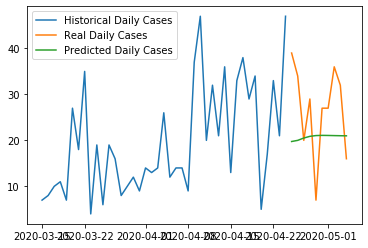

BROOME
Epoch 0 train loss: 9.530518531799316 test loss: 5.7781476974487305
Epoch 10 train loss: 2.48282527923584 test loss: 2.504159688949585
Epoch 20 train loss: 2.25132155418396 test loss: 2.4172022342681885
Epoch 30 train loss: 2.206840991973877 test loss: 2.0385687351226807
Epoch 40 train loss: 2.12609601020813 test loss: 2.146892786026001
Epoch 50 train loss: 2.043125629425049 test loss: 2.1350224018096924
[299. 305. 327. 334. 338. 345. 360. 364. 372. 373.]
[293.1869067  302.33975387 311.72566545 321.49613774 331.73227572
 342.49224746 353.84086752 365.86293256 378.66744542 392.38797557]


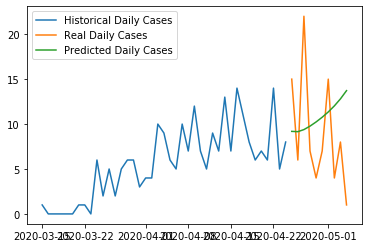

CATTARAUGUS
Epoch 0 train loss: 1.743177056312561 test loss: 0.5008149743080139
Epoch 10 train loss: 1.215863823890686 test loss: 0.2982476055622101
Epoch 20 train loss: 1.2050875425338745 test loss: 0.29462340474128723
Epoch 30 train loss: 1.1436206102371216 test loss: 0.28739142417907715
Epoch 40 train loss: 1.1004798412322998 test loss: 0.3069535493850708
Epoch 50 train loss: 1.097225546836853 test loss: 0.308745414018631
[49. 50. 53. 53. 53. 54. 59. 59. 60. 60.]
[47.93246272 49.07532637 50.31470662 51.52967918 52.65629923 53.69467689
 54.68386766 55.66935927 56.68046945 57.72377285]


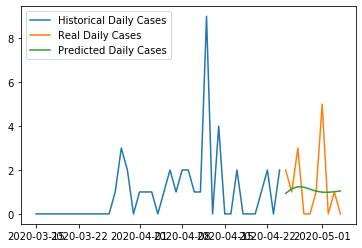

CHAUTAUQUA
Epoch 0 train loss: 8.944412231445312 test loss: 2.4445531368255615
Epoch 10 train loss: 1.4568419456481934 test loss: 0.2438098043203354
Epoch 20 train loss: 0.7421042323112488 test loss: 0.023848881945014
Epoch 30 train loss: 0.7204469442367554 test loss: 0.02252495288848877
Epoch 40 train loss: 0.7196198105812073 test loss: 0.022464830428361893
Epoch 50 train loss: 0.6726651787757874 test loss: 0.017149582505226135
[35.       35.       36.       37.       37.       38.       40.000004
 40.000004 40.000004 41.000004]
[33.57691932 34.17233622 34.78244305 35.40114403 36.02384669 36.64795625
 37.27230114 37.89648831 38.52046394 39.14427936]


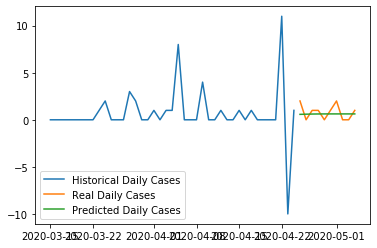

CHEMUNG
Epoch 0 train loss: 2.1760711669921875 test loss: 0.02230742760002613
Epoch 10 train loss: 1.5900129079818726 test loss: 0.14219895005226135
Epoch 20 train loss: 1.6149615049362183 test loss: 0.09327416867017746
Epoch 30 train loss: 1.5899319648742676 test loss: 0.12879644334316254
Epoch 40 train loss: 1.5678085088729858 test loss: 0.12266340851783752
Epoch 50 train loss: 1.5941758155822754 test loss: 0.12119275331497192
[123. 124. 125. 126. 126. 128. 129. 130. 131. 131.]
[124.24538732 126.53770599 128.83482376 131.13011712 133.42388517
 135.71680629 138.00918075 140.30112556 142.59272012 144.88404465]


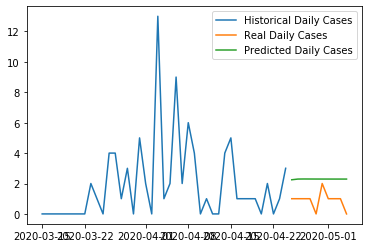

CHENANGO
Epoch 0 train loss: 6.422150611877441 test loss: 0.5892518162727356
Epoch 10 train loss: 3.221889019012451 test loss: 0.44503143429756165
Epoch 20 train loss: 2.8055057525634766 test loss: 0.799348771572113
Epoch 30 train loss: 2.742997646331787 test loss: 0.643210768699646
Epoch 40 train loss: 2.7286853790283203 test loss: 0.7006852030754089
Epoch 50 train loss: 2.7722175121307373 test loss: 0.7068372964859009
[ 99.  99.  99. 100. 100. 102. 105. 105. 109. 109.]
[100.35846937 102.74891543 105.14803201 107.5449698  109.93692458
 112.3244617  114.70893133 117.09150171 119.47296935 121.85382491]


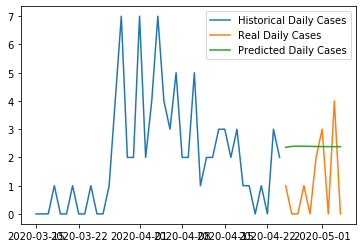

CORTLAND
Epoch 0 train loss: 2.8955185413360596 test loss: 0.062347497791051865
Epoch 10 train loss: 2.322970390319824 test loss: 0.2939048111438751
Epoch 20 train loss: 2.313781261444092 test loss: 0.22789275646209717
Epoch 30 train loss: 2.2478880882263184 test loss: 0.19138585031032562
Epoch 40 train loss: 2.2271511554718018 test loss: 0.07578203082084656
Epoch 50 train loss: 2.0583696365356445 test loss: 0.18275193870067596
[28. 28. 28. 28. 28. 28. 29. 29. 29. 29.]
[27.85394301 27.74728209 27.63956629 27.49831358 27.30087461 27.0322742
 26.68269344 26.24557443 25.71644689 25.092308  ]


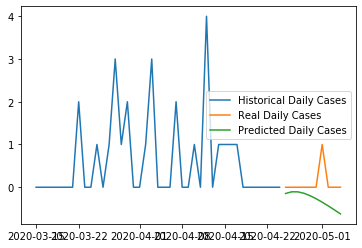

DELAWARE
Epoch 0 train loss: 12.293785095214844 test loss: 2.818251848220825
Epoch 10 train loss: 0.705811619758606 test loss: 0.06985733658075333
Epoch 20 train loss: 0.6305512189865112 test loss: 0.04110376164317131
Epoch 30 train loss: 0.7115345001220703 test loss: 0.010249592363834381
Epoch 40 train loss: 0.6679220795631409 test loss: 0.010681389831006527
Epoch 50 train loss: 0.6614112257957458 test loss: 0.017433002591133118
[61.       61.       61.       62.       62.       62.       62.999996
 62.999996 62.999996 63.999996]
[62.31616342 63.57881826 64.8247689  66.06929648 67.31667316 68.56685573
 69.81873405 71.07134104 72.32411343 73.57680833]


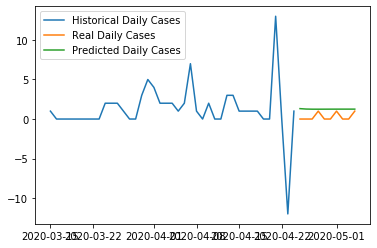

DUTCHESS
Epoch 0 train loss: 9.982298851013184 test loss: 0.6239005327224731
Epoch 10 train loss: 3.6640853881835938 test loss: 0.04624781012535095
Epoch 20 train loss: 2.7085816860198975 test loss: 0.4566606879234314
Epoch 30 train loss: 2.6527798175811768 test loss: 0.5395835638046265
Epoch 40 train loss: 2.714148998260498 test loss: 0.4578392803668976
Epoch 50 train loss: 2.602614641189575 test loss: 0.5703917741775513
[3002. 3049. 3086. 3131. 3151. 3192. 3233. 3277. 3319. 3359.]
[3025.65899724 3096.95453942 3167.68269831 3237.89071071 3307.72421426
 3377.32996804 3446.81705427 3516.2528072  3585.67265654 3655.09211653]


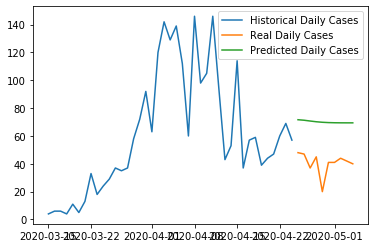

ERIE
Epoch 0 train loss: 4.002573490142822 test loss: 1.8133357763290405
Epoch 10 train loss: 1.7119648456573486 test loss: 0.34785693883895874
Epoch 20 train loss: 1.7133549451828003 test loss: 0.42076313495635986
Epoch 30 train loss: 1.7240219116210938 test loss: 0.3159276247024536
Epoch 40 train loss: 1.7141774892807007 test loss: 0.31554508209228516
Epoch 50 train loss: 1.7085274457931519 test loss: 0.3324250876903534
[3481. 3598. 3710. 3802. 3891. 4008. 4136. 4255. 4337. 4453.]
[3392.97431457 3466.50991964 3539.79496929 3613.06179672 3686.40655479
 3759.8369408  3833.33106714 3906.86609623 3980.4259153  4054.00060537]


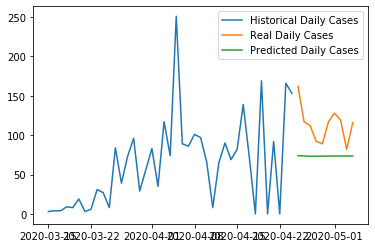

ESSEX
Epoch 0 train loss: 6.269193172454834 test loss: 1.1870722770690918
Epoch 10 train loss: 2.730992078781128 test loss: 0.330122172832489
Epoch 20 train loss: 1.7566970586776733 test loss: 0.2567412555217743
Epoch 30 train loss: 1.6393710374832153 test loss: 0.15000402927398682
Epoch 40 train loss: 1.632277488708496 test loss: 0.20663964748382568
Epoch 50 train loss: 1.6573683023452759 test loss: 0.16586288809776306
[28. 28. 29. 29. 30. 30. 30. 31. 31. 32.]
[28.60169053 29.21353579 29.82700992 30.43955612 31.05100417 31.66176939
 32.27221441 32.8825376  33.4928205  34.10308909]


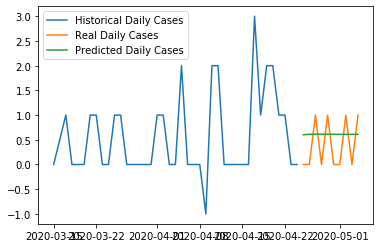

FRANKLIN
Epoch 0 train loss: 2.659971237182617 test loss: 0.2038964033126831
Epoch 10 train loss: 2.244278907775879 test loss: 0.23837631940841675
Epoch 20 train loss: 2.198035955429077 test loss: 0.21045422554016113
Epoch 30 train loss: 2.2006399631500244 test loss: 0.21665236353874207
Epoch 40 train loss: 2.144864559173584 test loss: 0.20024144649505615
Epoch 50 train loss: 2.0948452949523926 test loss: 0.24177482724189758
[15. 15. 15. 16. 16. 16. 16. 17. 17. 17.]
[15.50289604 15.93431626 16.33266637 16.74221845 17.18565054 17.66793314
 18.18636931 18.73692781 19.31630132 19.92179154]


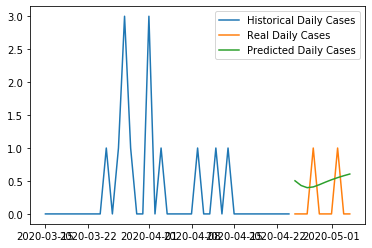

FULTON
Epoch 0 train loss: 3.583056926727295 test loss: 13.971839904785156
Epoch 10 train loss: 2.7083234786987305 test loss: 11.778491020202637
Epoch 20 train loss: 2.6780877113342285 test loss: 11.39321231842041
Epoch 30 train loss: 2.6627631187438965 test loss: 10.96512222290039
Epoch 40 train loss: 2.614523410797119 test loss: 10.777669906616211
Epoch 50 train loss: 2.5092203617095947 test loss: 10.656841278076172
[ 75.  79.  82.  84.  97. 100. 101. 103. 104. 107.]
[70.69672781 71.15602344 72.2358647  73.55732864 74.82273    75.88768488
 76.73096466 77.40220582 77.9818002  78.55476028]


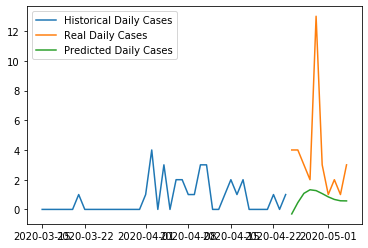

GENESEE
Epoch 0 train loss: 1.35097074508667 test loss: 0.03856296092271805
Epoch 10 train loss: 1.1874562501907349 test loss: 0.08781701326370239
Epoch 20 train loss: 1.1506421566009521 test loss: 0.06028688699007034
Epoch 30 train loss: 1.1401445865631104 test loss: 0.05965131148695946
Epoch 40 train loss: 1.0252041816711426 test loss: 0.08101671934127808
Epoch 50 train loss: 1.0896315574645996 test loss: 0.058811504393815994
[154. 155. 155. 159. 159. 162. 168. 169. 170. 172.]
[157.11851674 160.037578   162.03437085 163.68679824 165.53833808
 167.93945561 171.02929848 174.76327251 178.94993167 183.30281983]


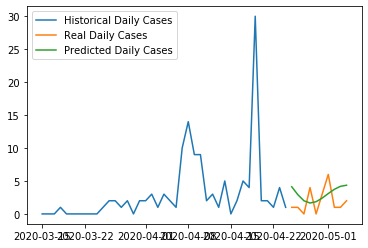

HERKIMER
Epoch 0 train loss: 8.184093475341797 test loss: 4.133085250854492
Epoch 10 train loss: 3.9133732318878174 test loss: 2.2462821006774902
Epoch 20 train loss: 3.3157713413238525 test loss: 1.644905924797058
Epoch 30 train loss: 3.2820780277252197 test loss: 1.7374612092971802
Epoch 40 train loss: 3.2698214054107666 test loss: 1.6897777318954468
Epoch 50 train loss: 3.2722678184509277 test loss: 1.7089520692825317
[60. 61. 62. 63. 67. 68. 74. 76. 77. 79.]
[59.52571273 61.03145146 62.54010224 64.05972457 65.58988059 67.12736177
 68.66904819 70.2127682  71.75726223 73.3019011 ]


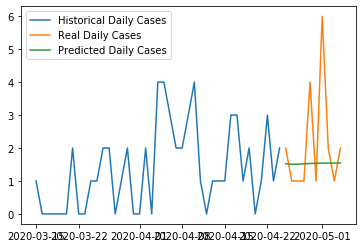

JEFFERSON
Epoch 0 train loss: 4.050661563873291 test loss: 0.15550698339939117
Epoch 10 train loss: 2.137327194213867 test loss: 0.33884039521217346
Epoch 20 train loss: 2.168156623840332 test loss: 0.28914543986320496
Epoch 30 train loss: 2.1432836055755615 test loss: 0.3441312909126282
Epoch 40 train loss: 2.0715901851654053 test loss: 0.4125754237174988
Epoch 50 train loss: 1.9942948818206787 test loss: 0.31392577290534973
[61. 62. 62. 63. 63. 63. 64. 66. 67. 68.]
[62.31371206 63.48642686 64.57987791 65.64989093 66.74247476 67.88520473
 69.08442715 70.3295441  71.60123229 72.87976018]


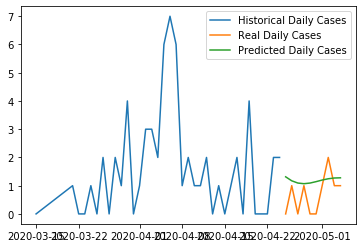

MADISON
Epoch 0 train loss: 15.583946228027344 test loss: 13.676979064941406
Epoch 10 train loss: 1.4047895669937134 test loss: 4.757684707641602
Epoch 20 train loss: 1.3038791418075562 test loss: 4.8326849937438965
Epoch 30 train loss: 1.2452062368392944 test loss: 4.864450454711914
Epoch 40 train loss: 1.1847096681594849 test loss: 5.086287498474121
Epoch 50 train loss: 1.2148714065551758 test loss: 5.063727855682373
[139. 149. 151. 217. 223. 231. 246. 249. 250. 251.]
[134.65206075 138.02959585 141.26090765 144.42732143 147.57055044
 150.70801497 153.84509897 156.98250175 160.11972594 163.25634432]


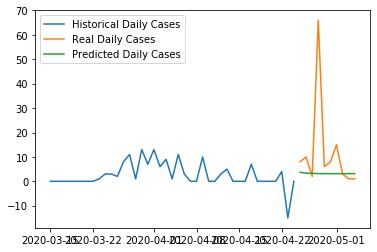

MONROE
Epoch 0 train loss: 4.580183506011963 test loss: 1.3953449726104736
Epoch 10 train loss: 1.4826360940933228 test loss: 0.26659098267555237
Epoch 20 train loss: 1.25481379032135 test loss: 0.13820450007915497
Epoch 30 train loss: 1.2370177507400513 test loss: 0.10580363869667053
Epoch 40 train loss: 1.2624263763427734 test loss: 0.13167239725589752
Epoch 50 train loss: 1.2385615110397339 test loss: 0.10652097314596176
[1478. 1534. 1566. 1595. 1623. 1655. 1688. 1735. 1775. 1821.]
[1474.23084247 1507.12424159 1539.87142277 1572.58449966 1605.3081525
 1638.05156249 1670.81096917 1703.58045292 1736.35547543 1769.13328743]


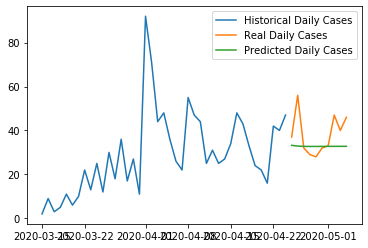

MONTGOMERY
Epoch 0 train loss: 1.2979332208633423 test loss: 0.31606099009513855
Epoch 10 train loss: 1.125137448310852 test loss: 0.2071450799703598
Epoch 20 train loss: 1.1120749711990356 test loss: 0.2247736006975174
Epoch 30 train loss: 1.123650312423706 test loss: 0.2173466831445694
Epoch 40 train loss: 1.090355396270752 test loss: 0.21447503566741943
Epoch 50 train loss: 1.1229090690612793 test loss: 0.21706192195415497
[54. 54. 56. 56. 61. 63. 63. 64. 66. 67.]
[54.10762715 55.21581221 56.32369968 57.43765268 58.56481913 59.7101568
 60.87563145 62.06048551 63.26196107 64.47614017]


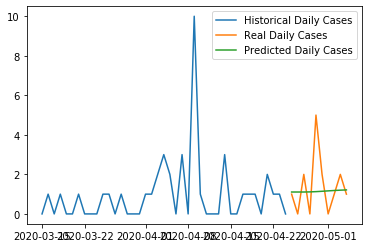

NASSAU
Epoch 0 train loss: 8.44442081451416 test loss: 0.10354991257190704
Epoch 10 train loss: 1.9128371477127075 test loss: 0.4072522521018982
Epoch 20 train loss: 1.2263520956039429 test loss: 1.085090160369873
Epoch 30 train loss: 1.2994050979614258 test loss: 1.2583922147750854
Epoch 40 train loss: 1.243169903755188 test loss: 1.087834358215332
Epoch 50 train loss: 1.2335376739501953 test loss: 1.3022770881652832
[36161. 36519. 36780. 36965. 37152. 37350. 37593. 37812. 38028. 38217.]
[36716.65744781 37593.69357228 38482.90112889 39379.96900523
 40281.23984087 41184.41057742 42088.29551113 42992.38765299
 43896.51402628 44800.63533878]


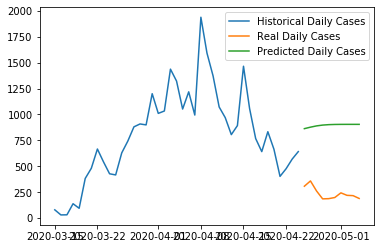

NEW YORK
Epoch 0 train loss: 12.276260375976562 test loss: 0.6496889591217041
Epoch 10 train loss: 0.9163066148757935 test loss: 0.9198098182678223
Epoch 20 train loss: 0.9558790326118469 test loss: 0.6348135471343994
Epoch 30 train loss: 0.9535895586013794 test loss: 0.7144076228141785
Epoch 40 train loss: 0.8701148629188538 test loss: 0.9364109635353088
Epoch 50 train loss: 0.9293334484100342 test loss: 0.9385969638824463
[169690. 172354. 174331. 175651. 176874. 178351. 180216. 181783. 183289.
 184417.]
[171390.2094444  175330.62159204 179327.51567996 183377.96611273
 187467.03057814 191579.46518433 195704.12014192 199834.25774366
 203966.38795739 208098.97281832]


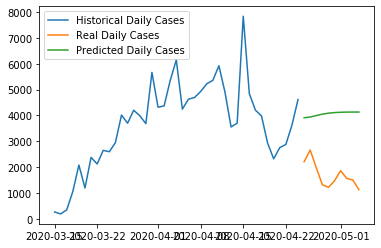

NIAGARA
Epoch 0 train loss: 4.934494972229004 test loss: 3.5591306686401367
Epoch 10 train loss: 2.1397132873535156 test loss: 1.537759780883789
Epoch 20 train loss: 1.9913407564163208 test loss: 1.199694037437439
Epoch 30 train loss: 1.9813940525054932 test loss: 1.0990827083587646
Epoch 40 train loss: 1.990097999572754 test loss: 1.2739979028701782
Epoch 50 train loss: 1.9599775075912476 test loss: 1.1645653247833252
[440. 457. 474. 493. 508. 549. 588. 605. 627. 643.]
[427.79602404 436.00765319 444.66919923 453.68415259 462.9148936
 472.25258715 481.63388339 491.02989127 500.43040943 509.83287738]


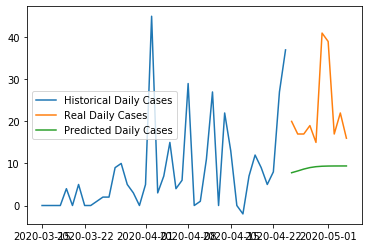

ONEIDA
Epoch 0 train loss: 3.8644299507141113 test loss: 6.067173480987549
Epoch 10 train loss: 1.6582167148590088 test loss: 3.653808832168579
Epoch 20 train loss: 1.6311872005462646 test loss: 4.027036666870117
Epoch 30 train loss: 1.5647603273391724 test loss: 4.699929714202881
Epoch 40 train loss: 1.3573801517486572 test loss: 6.910923480987549
Epoch 50 train loss: 1.1631619930267334 test loss: 8.204647064208984
[451. 474. 489. 550. 574. 579. 609. 620. 638. 660.]
[450.30690995 466.79821208 485.64116225 503.51769713 518.05289078
 528.55491558 535.87212585 541.69564705 547.77263623 555.31678177]


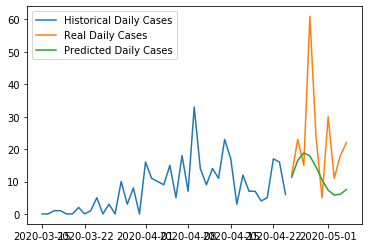

ONONDAGA
Epoch 0 train loss: 17.6086368560791 test loss: 8.396537780761719
Epoch 10 train loss: 1.2451733350753784 test loss: 1.0298094749450684
Epoch 20 train loss: 1.197799563407898 test loss: 1.0340496301651
Epoch 30 train loss: 0.9571771025657654 test loss: 0.4086627960205078
Epoch 40 train loss: 0.9124350547790527 test loss: 0.4752201437950134
Epoch 50 train loss: 0.9458410143852234 test loss: 0.641228199005127
[ 860.  903.  952.  971. 1002. 1056. 1115. 1169. 1218. 1265.]
[ 853.79135281  875.1754092   895.90997106  916.04238951  935.71678799
  955.07955194  974.24541938  993.29327232 1012.27305973 1031.21465367]


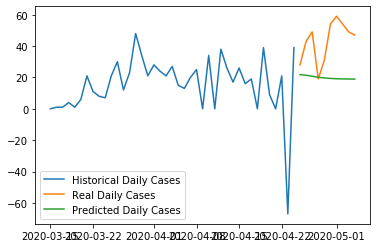

ONTARIO
Epoch 0 train loss: 4.423901557922363 test loss: 0.6039330363273621
Epoch 10 train loss: 1.791235089302063 test loss: 0.18067945539951324
Epoch 20 train loss: 1.7785738706588745 test loss: 0.14772067964076996
Epoch 30 train loss: 1.7637280225753784 test loss: 0.16457325220108032
Epoch 40 train loss: 1.7730516195297241 test loss: 0.17094211280345917
Epoch 50 train loss: 1.736981749534607 test loss: 0.15307952463626862
[ 91.  92.  95.  96.  97.  99. 101. 104. 104. 106.]
[ 91.76061928  93.56306612  95.46591115  97.46517444  99.51610446
 101.57254434 103.60852408 105.619452   107.6131568  109.60032463]


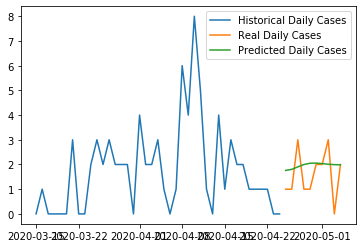

ORANGE
Epoch 0 train loss: 11.70761489868164 test loss: 1.808000087738037
Epoch 10 train loss: 2.563744068145752 test loss: 0.06085720658302307
Epoch 20 train loss: 1.3116891384124756 test loss: 0.0853758156299591
Epoch 30 train loss: 1.2458332777023315 test loss: 0.21312136948108673
Epoch 40 train loss: 1.2560213804244995 test loss: 0.09573835134506226
Epoch 50 train loss: 1.2833459377288818 test loss: 0.20098647475242615
[8751. 8910. 8967. 9015. 9144. 9215. 9328. 9402. 9486. 9543.]
[ 8838.68568969  9028.36729872  9219.12213492  9410.80866551
  9603.21032047  9796.11577374  9989.35419124 10182.80258328
 10376.37920898 10570.03238565]


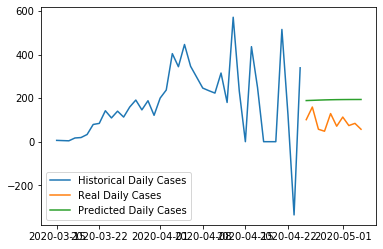

ORLEANS
Epoch 0 train loss: 4.540462493896484 test loss: 4.903510093688965
Epoch 10 train loss: 2.8477723598480225 test loss: 3.2644143104553223
Epoch 20 train loss: 2.7216999530792236 test loss: 3.2377376556396484
Epoch 30 train loss: 2.1809418201446533 test loss: 2.974601984024048
Epoch 40 train loss: 2.001025676727295 test loss: 3.76595139503479
Epoch 50 train loss: 1.8869062662124634 test loss: 4.123822212219238
[ 92.  93.  97.  97.  99. 103. 108. 121. 122. 126.]
[ 97.32819545 105.93786931 113.3110913  118.86111569 122.73453587
 125.15342489 126.13467242 125.68539624 124.00461282 121.41656314]


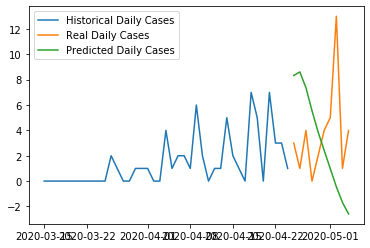

OTSEGO
Epoch 0 train loss: 3.3246564865112305 test loss: 0.002508852630853653
Epoch 10 train loss: 2.125453233718872 test loss: 0.29702693223953247
Epoch 20 train loss: 2.0794925689697266 test loss: 0.41324108839035034
Epoch 30 train loss: 2.0921502113342285 test loss: 0.4352478086948395
Epoch 40 train loss: 2.051832914352417 test loss: 0.4104738235473633
Epoch 50 train loss: 2.021726608276367 test loss: 0.49278223514556885
[67. 67. 67. 67. 67. 67. 67. 67. 67. 67.]
[68.02021798 68.59377928 68.67434908 68.34986647 67.85897578 67.52646457
 67.65510142 68.42068898 69.81110548 71.62629138]


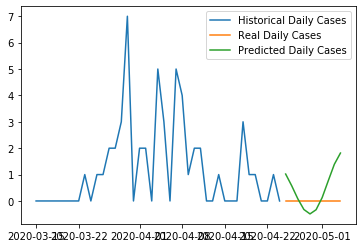

PUTNAM
Epoch 0 train loss: 18.93592071533203 test loss: 4.973042964935303
Epoch 10 train loss: 0.8486950397491455 test loss: 0.047782231122255325
Epoch 20 train loss: 0.9066250324249268 test loss: 0.0467364564538002
Epoch 30 train loss: 0.7339852452278137 test loss: 0.017002271488308907
Epoch 40 train loss: 0.712691068649292 test loss: 0.026243804022669792
Epoch 50 train loss: 0.6819271445274353 test loss: 0.012087647803127766
[ 990. 1003. 1013. 1026. 1031. 1040. 1066. 1074. 1080. 1089.]
[ 979.39524347  991.7929914  1005.70947152 1020.26917315 1035.04288667
 1049.85464722 1064.64900959 1079.41840935 1094.16930693 1108.90953255]


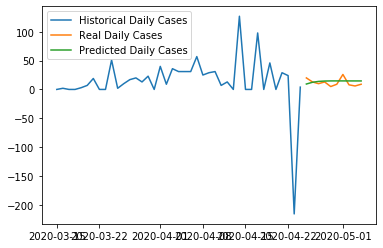

RENSSELAER
Epoch 0 train loss: 7.357438087463379 test loss: 3.837958574295044
Epoch 10 train loss: 2.5849454402923584 test loss: 1.6951593160629272
Epoch 20 train loss: 1.465930700302124 test loss: 0.5351583361625671
Epoch 30 train loss: 1.3951337337493896 test loss: 0.7769324779510498
Epoch 40 train loss: 1.3904067277908325 test loss: 0.6263866424560547
Epoch 50 train loss: 1.3708467483520508 test loss: 0.6913893222808838
[298. 311. 322. 337. 339. 347. 367. 380. 407. 409.]
[292.677441   298.5068574  304.32533169 310.03162509 315.61092693
 321.09090841 326.50623274 331.88363683 337.23989058 342.58441287]


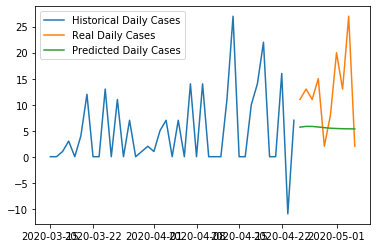

ROCKLAND
Epoch 0 train loss: 10.712960243225098 test loss: 0.2237391173839569
Epoch 10 train loss: 3.005553960800171 test loss: 0.29349029064178467
Epoch 20 train loss: 1.7669123411178589 test loss: 1.1935771703720093
Epoch 30 train loss: 1.7126456499099731 test loss: 1.214611530303955
Epoch 40 train loss: 1.7320319414138794 test loss: 1.1802451610565186
Epoch 50 train loss: 1.719348430633545 test loss: 1.2361425161361694
[11812. 11945. 12025. 12095. 12144. 12204. 12280. 12349. 12400. 12451.]
[11979.42662099 12253.88024414 12531.61052266 12811.87767684
 13093.85385469 13376.89953119 13660.58825281 13944.65676898
 14228.94919309 14513.3747955 ]


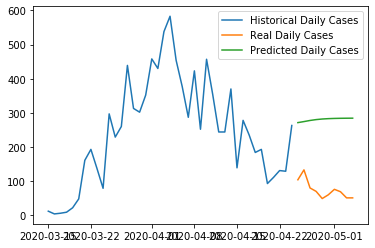

SARATOGA
Epoch 0 train loss: 12.138713836669922 test loss: 2.507384777069092
Epoch 10 train loss: 1.1354691982269287 test loss: 0.1599816083908081
Epoch 20 train loss: 1.2125921249389648 test loss: 0.13153018057346344
Epoch 30 train loss: 1.1789758205413818 test loss: 0.14658653736114502
Epoch 40 train loss: 1.165642261505127 test loss: 0.18473076820373535
Epoch 50 train loss: 1.0866146087646484 test loss: 0.1941574513912201
[358. 361. 363. 367. 368. 371. 374. 388. 399. 402.]
[361.12689179 368.42745453 375.82079935 383.24917293 390.68351084
 398.11349285 405.53770244 412.95767295 420.375211   427.7915808 ]


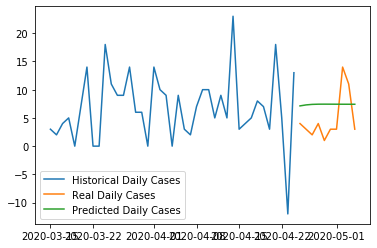

SCHENECTADY
Epoch 0 train loss: 16.263471603393555 test loss: 4.332204818725586
Epoch 10 train loss: 1.1101529598236084 test loss: 0.09744656831026077
Epoch 20 train loss: 0.8467973470687866 test loss: 0.045133959501981735
Epoch 30 train loss: 0.7585384845733643 test loss: 0.025696460157632828
Epoch 40 train loss: 0.8017043471336365 test loss: 0.030494773760437965
Epoch 50 train loss: 0.7322619557380676 test loss: 0.017861712723970413
[514. 521. 527. 535. 537. 551. 551. 558. 571. 571.]
[506.21205115 512.18332696 518.59914744 525.23267746 531.95193231
 538.69261837 545.42937016 552.15564418 558.87232375 565.58222878]


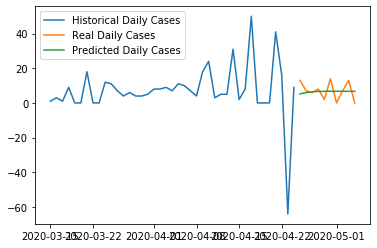

SCHOHARIE
Epoch 0 train loss: 2.363834857940674 test loss: 0.39515721797943115
Epoch 10 train loss: 0.950851559638977 test loss: 0.055855102837085724
Epoch 20 train loss: 0.9567550420761108 test loss: 0.053185880184173584
Epoch 30 train loss: 0.9539700746536255 test loss: 0.06238282844424248
Epoch 40 train loss: 0.9567636847496033 test loss: 0.052548039704561234
Epoch 50 train loss: 0.9409381151199341 test loss: 0.05546565726399422
[43. 43. 45. 45. 45. 45. 45. 45. 46. 46.]
[42.54836161 43.12712969 43.71247923 44.29071435 44.86207953 45.4302561
 45.99764758 46.56511109 47.13276194 47.70052344]


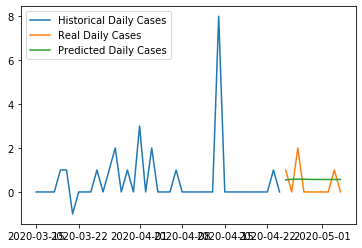

SUFFOLK
Epoch 0 train loss: 9.772414207458496 test loss: 0.25600457191467285
Epoch 10 train loss: 3.5861480236053467 test loss: 0.13999654352664948
Epoch 20 train loss: 2.1997201442718506 test loss: 1.0224354267120361
Epoch 30 train loss: 2.2010657787323 test loss: 0.8891574144363403
Epoch 40 train loss: 2.2192368507385254 test loss: 0.9605906009674072
Epoch 50 train loss: 2.22226881980896 test loss: 1.0110371112823486
[34037. 34478. 34855. 35077. 35275. 35543. 35892. 36223. 36461. 36702.]
[34522.28015161 35384.56635618 36249.46947658 37114.13136125
 37976.70414019 38836.61049438 39694.08182192 40549.6779052
 41403.98579395 42257.48571408]


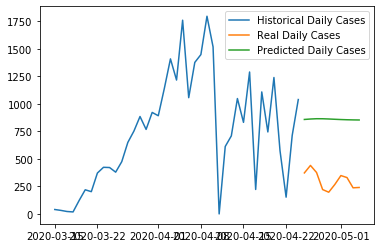

SULLIVAN
Epoch 0 train loss: 7.206840515136719 test loss: 2.7520365715026855
Epoch 10 train loss: 2.471073627471924 test loss: 0.9667362570762634
Epoch 20 train loss: 1.5119436979293823 test loss: 0.25353217124938965
Epoch 30 train loss: 1.4434325695037842 test loss: 0.4016607701778412
Epoch 40 train loss: 1.4208059310913086 test loss: 0.3190508186817169
Epoch 50 train loss: 1.4237397909164429 test loss: 0.34078899025917053
[ 880.  931.  951.  976.  984.  996. 1021. 1039. 1071. 1093.]
[ 856.31268835  874.45013905  892.42723894  910.29416084  928.0932622
  945.85284567  963.59012985  981.31514502  999.03357029 1016.74856234]


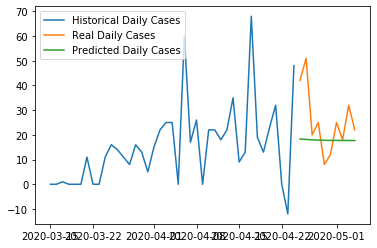

TOMPKINS
Epoch 0 train loss: 5.18875789642334 test loss: 0.3742658793926239
Epoch 10 train loss: 1.7482956647872925 test loss: 0.019753091037273407
Epoch 20 train loss: 1.4287619590759277 test loss: 0.18683302402496338
Epoch 30 train loss: 1.4250433444976807 test loss: 0.20034226775169373
Epoch 40 train loss: 1.418181300163269 test loss: 0.15535975992679596
Epoch 50 train loss: 1.4300258159637451 test loss: 0.2207694798707962
[128. 128. 129. 129. 129. 129. 130. 131. 132. 132.]
[130.91348791 133.9094013  136.96769154 140.06551993 143.18583477
 146.31813848 149.45666194 152.59843206 155.7419486  158.88644147]


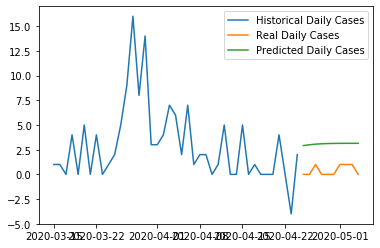

ULSTER
Epoch 0 train loss: 15.270933151245117 test loss: 3.36643385887146
Epoch 10 train loss: 1.2593767642974854 test loss: 0.17429998517036438
Epoch 20 train loss: 1.143228530883789 test loss: 0.11903519928455353
Epoch 30 train loss: 1.1374993324279785 test loss: 0.08551755547523499
Epoch 40 train loss: 1.0679936408996582 test loss: 0.048718683421611786
Epoch 50 train loss: 1.116543173789978 test loss: 0.04880300164222717
[1298. 1327. 1341. 1354. 1357. 1383. 1416. 1429. 1440. 1450.]
[1304.48896694 1330.72338295 1357.53332424 1384.68827438 1412.01415539
 1439.40817165 1466.82028389 1494.2312212  1521.63640976 1549.03679371]


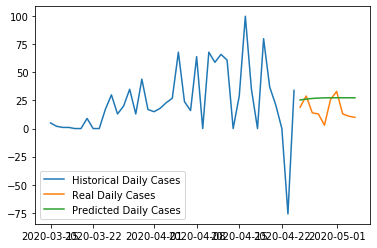

WARREN
Epoch 0 train loss: 1.5702719688415527 test loss: 0.1524181216955185
Epoch 10 train loss: 1.1252871751785278 test loss: 0.05900098383426666
Epoch 20 train loss: 1.1154005527496338 test loss: 0.05309576541185379
Epoch 30 train loss: 1.107755422592163 test loss: 0.056989654898643494
Epoch 40 train loss: 0.981616735458374 test loss: 0.13655522465705872
Epoch 50 train loss: 0.9585453271865845 test loss: 0.16792988777160645
[182. 185. 188. 192. 192. 193. 193. 199. 202. 207.]
[180.78699881 181.75931016 180.93911699 180.49761271 181.92621056
 185.68455837 191.27682013 197.64563216 203.70038066 208.75026885]


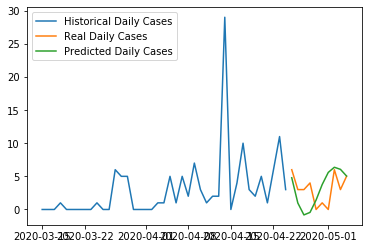

WAYNE
Epoch 0 train loss: 2.440124750137329 test loss: 0.17223414778709412
Epoch 10 train loss: 1.5891607999801636 test loss: 0.10152836889028549
Epoch 20 train loss: 1.5543179512023926 test loss: 0.12627488374710083
Epoch 30 train loss: 1.5566269159317017 test loss: 0.13381366431713104
Epoch 40 train loss: 1.5308961868286133 test loss: 0.1261691153049469
Epoch 50 train loss: 1.4986708164215088 test loss: 0.14269401133060455
[71. 73. 75. 76. 78. 78. 78. 79. 79. 80.]
[72.32089017 73.64291036 75.04823795 76.53949372 78.0859503  79.66068447
 81.24956769 82.84666799 84.44908993 86.0548193 ]


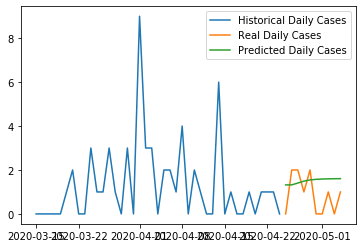

WESTCHESTER
Epoch 0 train loss: 8.917163848876953 test loss: 0.2637907564640045
Epoch 10 train loss: 2.9527854919433594 test loss: 0.08633127808570862
Epoch 20 train loss: 1.2525595426559448 test loss: 1.1529721021652222
Epoch 30 train loss: 1.2229892015457153 test loss: 0.7752386927604675
Epoch 40 train loss: 1.221242070198059 test loss: 0.9491018056869507
Epoch 50 train loss: 1.2178817987442017 test loss: 0.9271544218063354
[29232. 29626. 29884. 30097. 30240. 30426. 30708. 30905. 31087. 31294.]
[29677.34233272 30393.11828455 31115.08128631 31840.71496782
 32568.33334586 33297.00002158 34026.23359746 34755.78782016
 35485.53061396 36215.38658839]


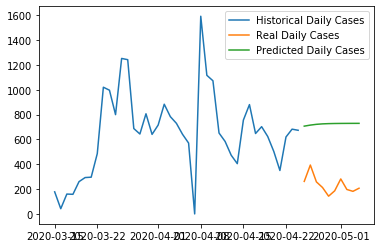

WYOMING
Epoch 0 train loss: 4.89490270614624 test loss: 1.0868475437164307
Epoch 10 train loss: 1.476176381111145 test loss: 0.16878822445869446
Epoch 20 train loss: 0.9054721593856812 test loss: 0.04542969539761543
Epoch 30 train loss: 0.9189406037330627 test loss: 0.035926833748817444
Epoch 40 train loss: 0.8991380333900452 test loss: 0.03920082375407219
Epoch 50 train loss: 0.8871147632598877 test loss: 0.03787977620959282
[68. 69. 69. 69. 70. 70. 71. 73. 75. 77.]
[68.1034475  69.21655828 70.31982872 71.40739274 72.48232692 73.54977944
 74.61367342 75.67618737 76.73828289 77.80030209]


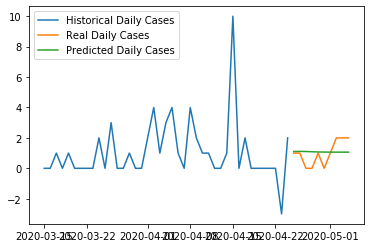

ALLEGANY
Epoch 0 train loss: 4.499054908752441 test loss: 0.058063406497240067
Epoch 10 train loss: 3.1475107669830322 test loss: 0.359578937292099
Epoch 20 train loss: 3.1508536338806152 test loss: 0.3408406674861908
Epoch 30 train loss: 3.140807867050171 test loss: 0.4732293486595154
Epoch 40 train loss: 3.1100988388061523 test loss: 0.40887412428855896
Epoch 50 train loss: 3.1167023181915283 test loss: 0.4475135803222656
[35. 35. 35. 35. 35. 35. 35. 35. 35. 36.]
[35.88740993 36.77052009 37.65312445 38.53057694 39.40018225 40.26215261
 41.11824739 41.97052526 42.82069153 43.66991109]


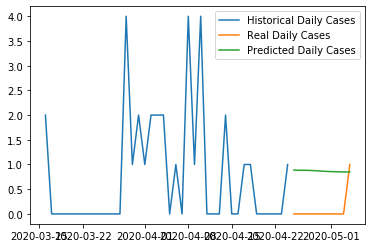

CAYUGA
Epoch 0 train loss: 1.4286154508590698 test loss: 0.2786564826965332
Epoch 10 train loss: 1.1508138179779053 test loss: 0.22770637273788452
Epoch 20 train loss: 1.1490962505340576 test loss: 0.21501843631267548
Epoch 30 train loss: 1.1308722496032715 test loss: 0.21032151579856873
Epoch 40 train loss: 1.135925531387329 test loss: 0.2123270332813263
Epoch 50 train loss: 1.1247189044952393 test loss: 0.2217199206352234
[51. 51. 51. 51. 51. 51. 52. 52. 53. 58.]
[49.150509   50.27137437 51.3911794  52.51808217 53.65138541 54.7890389
 55.9295956  57.07218844 58.21625812 59.36140439]


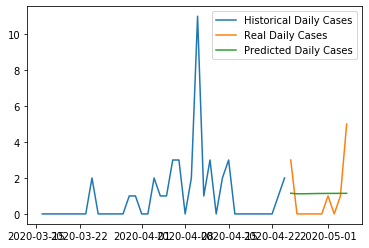

LIVINGSTON
Epoch 0 train loss: 4.035312175750732 test loss: 3.4177844524383545
Epoch 10 train loss: 2.5613269805908203 test loss: 1.816959261894226
Epoch 20 train loss: 2.546983242034912 test loss: 1.8240704536437988
Epoch 30 train loss: 2.513957977294922 test loss: 1.6965081691741943
Epoch 40 train loss: 2.4684321880340576 test loss: 1.7819610834121704
Epoch 50 train loss: 2.5161430835723877 test loss: 1.8906704187393188
[ 73.  76.  83.  85.  86.  89.  95. 100. 101. 102.]
[69.95497325 71.75073114 73.71293518 75.16969061 76.05974248 76.87680792
 78.06660818 79.58561637 81.07031637 82.27900495]


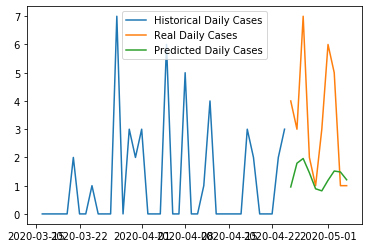

SCHUYLER
Epoch 0 train loss: 2.9618968963623047 test loss: 0.38606709241867065
Epoch 10 train loss: 0.8367385268211365 test loss: 0.018990490585565567
Epoch 20 train loss: 0.8697691559791565 test loss: 0.007978684268891811
Epoch 30 train loss: 0.8461999297142029 test loss: 0.051705434918403625
Epoch 40 train loss: 0.8667283058166504 test loss: 0.021766068413853645
Epoch 50 train loss: 0.8544030785560608 test loss: 0.017217515036463737
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
[7.19824862 7.40473557 7.61424232 7.82423139 8.03416061 8.24417019
 8.45442224 8.66494966 8.87569833 9.08659315]


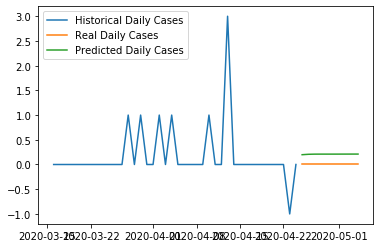

STEUBEN
Epoch 0 train loss: 14.584970474243164 test loss: 3.3667898178100586
Epoch 10 train loss: 0.8842166662216187 test loss: 0.006283005699515343
Epoch 20 train loss: 1.077851414680481 test loss: 0.002393093192949891
Epoch 30 train loss: 0.9481841325759888 test loss: 0.005861077457666397
Epoch 40 train loss: 0.8839176893234253 test loss: 0.04835107922554016
Epoch 50 train loss: 0.898561954498291 test loss: 0.026396455243229866
[216.      217.      218.      219.      221.      223.      224.
 225.      226.00002 227.00002]
[220.8426581  225.54993051 230.22823304 234.9219299  239.64105046
 244.38182664 249.13735318 253.90169513 258.67083204 263.44238818]


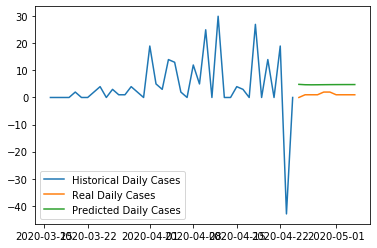

CLINTON
Epoch 0 train loss: 14.01669692993164 test loss: 4.449754238128662
Epoch 10 train loss: 1.3525559902191162 test loss: 0.3309765160083771
Epoch 20 train loss: 1.3221510648727417 test loss: 0.3312511444091797
Epoch 30 train loss: 1.370688557624817 test loss: 0.367255836725235
Epoch 40 train loss: 1.3030540943145752 test loss: 0.34885692596435547
Epoch 50 train loss: 1.283990740776062 test loss: 0.3459320366382599
[61. 62. 66. 68. 69. 69. 69. 74. 76. 76.]
[60.43341196 61.87559688 63.32657194 64.78325903 66.24264765 67.70282
 69.16288668 70.62259609 72.08199114 73.54119468]


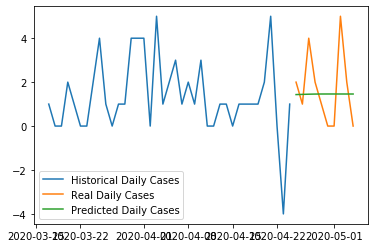

OSWEGO
Epoch 0 train loss: 14.086498260498047 test loss: 3.2760567665100098
Epoch 10 train loss: 2.2226908206939697 test loss: 0.23387083411216736
Epoch 20 train loss: 2.231489896774292 test loss: 0.2297750860452652
Epoch 30 train loss: 2.078625202178955 test loss: 0.1785721480846405
Epoch 40 train loss: 2.1007754802703857 test loss: 0.17243938148021698
Epoch 50 train loss: 2.150225877761841 test loss: 0.15732911229133606
[64. 66. 66. 67. 68. 70. 70. 72. 75. 75.]
[64.61538935 66.23155928 67.84651041 69.45561361 71.05759096 72.65389347
 74.24683857 75.83838129 77.42970753 79.02133083]


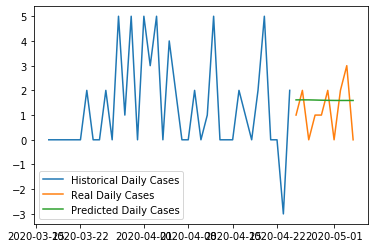

LEWIS
Epoch 0 train loss: 2.1552679538726807 test loss: 0.2875313460826874
Epoch 10 train loss: 1.604932188987732 test loss: 0.18769407272338867
Epoch 20 train loss: 1.6119451522827148 test loss: 0.1736958622932434
Epoch 30 train loss: 1.631108283996582 test loss: 0.19035649299621582
Epoch 40 train loss: 1.6132622957229614 test loss: 0.17662577331066132
Epoch 50 train loss: 1.6161973476409912 test loss: 0.1581684648990631
[ 9.  9.  9.  9.  9.  9. 10. 10. 11. 11.]
[ 9.28230849  9.55568594  9.82761253 10.10016574 10.37330604 10.64671321
 10.92020792 11.19372444 11.4672436  11.7407598 ]


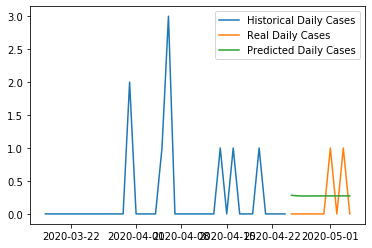

YATES
Epoch 0 train loss: 3.6743948459625244 test loss: 0.7270041108131409
Epoch 10 train loss: 2.707676887512207 test loss: 0.521874725818634
Epoch 20 train loss: 2.683103322982788 test loss: 0.5382266640663147
Epoch 30 train loss: 2.5475151538848877 test loss: 0.5810779333114624
Epoch 40 train loss: 2.25467586517334 test loss: 0.5233354568481445
Epoch 50 train loss: 2.169201612472534 test loss: 0.653352677822113
[18. 18. 19. 19. 19. 19. 19. 20. 20. 21.]
[18.23272508 17.77561837 17.33599168 17.16482027 17.15918218 17.2510312
 17.43024055 17.7151484  18.12005345 18.61263723]


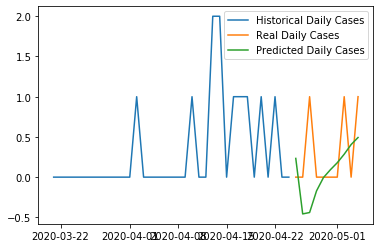

ST. LAWRENCE
Epoch 0 train loss: 4.905180931091309 test loss: 0.22742559015750885
Epoch 10 train loss: 2.418771505355835 test loss: 0.20914697647094727
Epoch 20 train loss: 2.0188088417053223 test loss: 0.6012731790542603
Epoch 30 train loss: 2.012242317199707 test loss: 0.5095235109329224
Epoch 40 train loss: 1.9948358535766602 test loss: 0.5080015659332275
Epoch 50 train loss: 2.012758493423462 test loss: 0.5535312294960022
[176. 176. 177. 178. 178. 180. 181. 187. 187. 187.]
[177.89128399 182.80694646 187.79696992 192.87068719 198.01426244
 203.20832127 208.43625402 213.68615112 218.95013481 224.22315493]


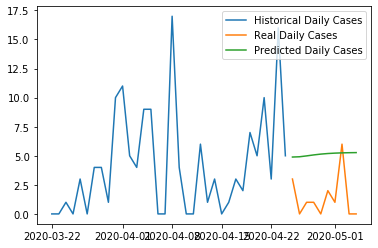

In [369]:
mydict = {"county":[], "loss":[]}
predictions = {}
confirmeds = {}
for county_name in cases_dict.keys():
    print(county_name)
    county_cases = cases_dict[county_name]['confirmed_cases']
    prev_value = county_cases[-11]
    county_cases = county_cases.diff().fillna(county_cases[0]).astype(np.int64)

    test_data_size = 16
    train_data = county_cases[:-test_data_size]
    test_data = county_cases[-test_data_size:]


    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(train_data, axis=1))
    
    train_data = scaler.transform(np.expand_dims(train_data, axis=1))
    test_data = scaler.transform(np.expand_dims(test_data, axis=1))


    seq_length = 5
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    model = CoronaVirusPredictor(
      n_features=1,
      n_hidden=512,
      seq_len=seq_length,
      n_layers=2
    )
    model, train_hist, test_hist = train_model(
      model,
      X_train,
      y_train,
      X_test,
      y_test
    )



    with torch.no_grad():

        test_seq = X_test[:1]
        preds = []
        for _ in range(len(X_test)):
            y_test_pred = model(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()


    true_cases = scaler.inverse_transform(
        np.expand_dims(y_test.flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = scaler.inverse_transform(
      np.expand_dims(preds, axis=0)
    ).flatten()

    predictions[county_name] = np.add.accumulate(predicted_cases) + prev_value
    confirmeds[county_name] = np.add.accumulate(true_cases) + prev_value

    print(np.add.accumulate(true_cases) + prev_value)
    print(np.add.accumulate(predicted_cases) + prev_value)
    plt.plot(
      county_cases.index[:len(train_data)],
      scaler.inverse_transform(train_data).flatten(),
      label='Historical Daily Cases'
    )
    plt.plot(
      county_cases.index[len(train_data):len(train_data) + len(true_cases)],
      true_cases,
      label='Real Daily Cases'
    )
    plt.plot(
      county_cases.index[len(train_data):len(train_data) + len(true_cases)],
      predicted_cases,
      label='Predicted Daily Cases'
    )
    plt.legend()
    plt.show()
    
    mydict['county'].append(county_name)
    mydict['loss'].append(np.mean((np.add.accumulate(predicted_cases)-np.add.accumulate(true_cases))**2))

In [371]:
confirmeds
pd.DataFrame(confirmeds).T

,0,1,2,3,4,5,6,7,8,9
ALBANY,1204.0,1238.0,1258.0,1287.0,1294.0,1321.0,1348.000000,1384.000000,1416.000000,1432.000000
BROOME,299.0,305.0,327.0,334.0,338.0,345.0,360.000000,364.000000,372.000000,373.000000
CATTARAUGUS,49.0,50.0,53.0,53.0,53.0,54.0,59.000000,59.000000,60.000000,60.000000
CHAUTAUQUA,35.0,35.0,36.0,37.0,37.0,38.0,40.000004,40.000004,40.000004,41.000004
CHEMUNG,123.0,124.0,125.0,126.0,126.0,128.0,129.000000,130.000000,131.000000,131.000000
CHENANGO,99.0,99.0,99.0,100.0,100.0,102.0,105.000000,105.000000,109.000000,109.000000
CORTLAND,28.0,28.0,28.0,28.0,28.0,28.0,29.000000,29.000000,29.000000,29.000000
DELAWARE,61.0,61.0,61.0,62.0,62.0,62.0,62.999996,62.999996,62.999996,63.999996
DUTCHESS,3002.0,3049.0,3086.0,3131.0,3151.0,3192.0,3233.000000,3277.000000,3319.000000,3359.000000
ERIE,3481.0,3598.0,3710.0,3802.0,3891.0,4008.0,4136.000000,4255.000000,4337.000000,4453.000000


In [374]:
predictions
pd.DataFrame(predictions).T.to_csv('RNN_predictions.csv')

,0,1,2,3,4,5,6,7,8,9
ALBANY,1184.753359,1204.753079,1225.261357,1246.135760,1267.178834,1288.262123,1309.329002,1330.365232,1351.374111,1372.363144
BROOME,293.186907,302.339754,311.725665,321.496138,331.732276,342.492247,353.840868,365.862933,378.667445,392.387976
CATTARAUGUS,47.932463,49.075326,50.314707,51.529679,52.656299,53.694677,54.683868,55.669359,56.680469,57.723773
CHAUTAUQUA,33.576919,34.172336,34.782443,35.401144,36.023847,36.647956,37.272301,37.896488,38.520464,39.144279
CHEMUNG,124.245387,126.537706,128.834824,131.130117,133.423885,135.716806,138.009181,140.301126,142.592720,144.884045
CHENANGO,100.358469,102.748915,105.148032,107.544970,109.936925,112.324462,114.708931,117.091502,119.472969,121.853825
CORTLAND,27.853943,27.747282,27.639566,27.498314,27.300875,27.032274,26.682693,26.245574,25.716447,25.092308
DELAWARE,62.316163,63.578818,64.824769,66.069296,67.316673,68.566856,69.818734,71.071341,72.324113,73.576808
DUTCHESS,3025.658997,3096.954539,3167.682698,3237.890711,3307.724214,3377.329968,3446.817054,3516.252807,3585.672657,3655.092117
ERIE,3392.974315,3466.509920,3539.794969,3613.061797,3686.406555,3759.836941,3833.331067,3906.866096,3980.425915,4054.000605
